In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [3]:
# The dataset contains 1 minute OHLCV data from 22 Jun 2019 to 01 Mar 2025 (2,991,782 records)
file_path = "..\data\ALGOUSDT.csv"
df = pd.read_csv(file_path, sep="|", header=None)
print(len(df))

2991782


In [4]:
# set column names
df.columns = ["timestamp", "open", "high", "low", "close", "volume", "Taker Buy Quote Asset Volume", 
                                              "Taker Buy Base Asset Volume", "Quote Asset Volume", "Number of trades"]
# convert unix timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', origin='unix')

# set timestamp as index
df = df.set_index("timestamp")

# sort by index
df = df.sort_index()

# display the first five rows
df.head()

,open,high,low,close,volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,Quote Asset Volume,Number of trades
timestamp,,,,,,,,,
2019-06-22 00:00:00,3.400,3.440,2.989,3.150,196437.510,364193.883,113795.250,626516.851,796
2019-06-22 00:01:00,3.150,3.151,3.019,3.039,157708.607,229296.225,73837.530,487567.859,595
2019-06-22 00:02:00,3.030,3.030,2.875,2.952,145305.629,204476.145,69792.845,426746.227,488
2019-06-22 00:03:00,2.952,2.971,2.893,2.950,95730.841,169035.600,57311.750,281784.965,245
2019-06-22 00:04:00,2.950,2.950,2.880,2.900,47611.763,50610.175,17251.687,138910.063,218


In [ ]:
def gen_plot(df, title=None):
    plt.figure(figsize=(12, 3))
    plt.plot(df)
    plt.title(title)
    plt.grid()
    plt.show()

### Check Dataset Completeness

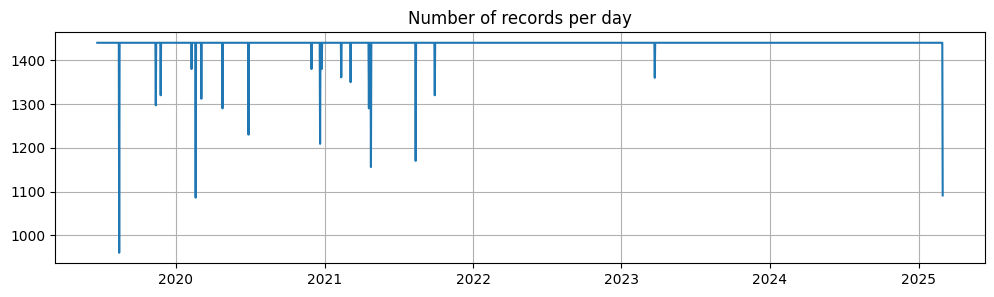

In [ ]:
# Calculate number of records per day
count = df['open'].resample('1D').apply(lambda x: x.count())

# Plot the number of records per day
gen_plot(count, "Number of records per day")

In [6]:
# Drop 2025-03-01 data
df = df[:'2025-02-28']

In [7]:
# Find days with incomplete records
incomplete_index = count[count != 1440].index
print(incomplete_index, len(incomplete_index))

DatetimeIndex(['2019-08-15', '2019-11-13', '2019-11-25', '2020-02-09',
               '2020-02-19', '2020-03-04', '2020-04-25', '2020-06-28',
               '2020-11-30', '2020-12-21', '2020-12-25', '2021-02-11',
               '2021-03-06', '2021-04-20', '2021-04-25', '2021-08-13',
               '2021-09-29', '2023-03-24', '2025-03-01'],
              dtype='datetime64[ns]', name='timestamp', freq=None) 19


In [8]:
# find number of days from 2019-06-22 to 2025-02-28
days = len(pd.date_range(start='2019-06-22', end='2025-02-28', freq='D'))
print(days)

2079


### Imputation

In [9]:
# impute missing records
# create a new dataframe with complete records
df_complete = pd.DataFrame(index=pd.date_range(start=df.index[0], end=df.index[-1], freq='min'))
df_complete = df_complete.join(df, how='left')
print(len(df_complete)==days*1440)

True


### Log Return

For $ t = 1, \dots, 2079 $:

$\quad$ For $ n = 1 $:

$$ r_{t,1} = log(p_{t,1}) - log(p_{t-1, 1440}) $$

$\quad$ For $ n = 2, 3, \dots, 1440 $:

$$ r_{t,n} = log(p_{t,n}) - log(p_{t, n-1}) $$

Exception: $r_{1, 1}$ is not defined. 

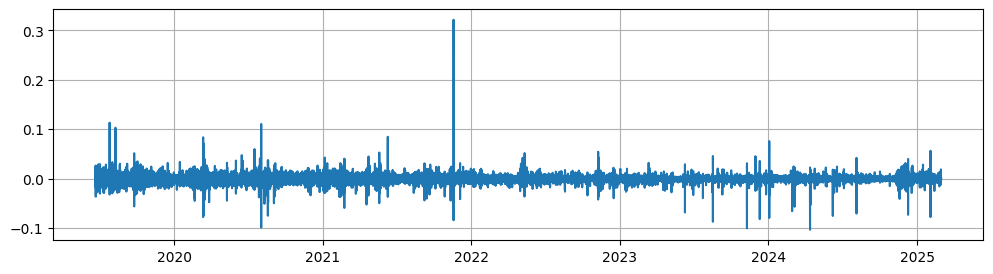

In [ ]:
# construct log return
df_complete['log_return'] = np.log(df_complete['close']).diff()

# drop NaN
df_complete = df_complete.dropna()

# plot log return
gen_plot(df_complete['log_return'])

In [11]:
# find the date where the log return is maximum
max_return_date = df_complete['log_return'].idxmax()
print(max_return_date)

2021-11-18 04:25:00


- the announced addition of an Algorand exchange-traded product (ETP) in Switzerland

### Resampling to Daily Records

$$ r_t = log(p_t) - log(p_{t-1}) $$

$$ RV_t = \sum_{n=1}^{1440} {r_{t, n}^2} $$

$$ lnRV_t = log(\sum_{n=1}^{1440} {r_{t, n}^2}) $$

In [ ]:
# resample to construct a new dataframe for daily OHLC records
df_daily = df_complete.resample('1D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})

# construct daily (log) return
df_daily['return'] = np.log(df_daily['close']).diff()

# construct daily realised volatility
df_daily['RV'] = df_complete['log_return'].resample('1D').apply(lambda x: np.sum(x**2))

# log transform daily realised volatility
df_daily['lnRV'] = np.log(df_daily['RV'])

# lag terms of log RV
df_daily['lnRV_lag7'] = np.mean([df_daily['lnRV'].shift(i) for i in range(1, 8)], axis=0)
df_daily['lnRV_lag30'] = np.mean([df_daily['lnRV'].shift(i) for i in range(1, 31)], axis=0)
df_daily['lnRV_lag60'] = np.mean([df_daily['lnRV'].shift(i) for i in range(1, 61)], axis=0)

# drop NaN
df_daily = df_daily.dropna()

### Daily Return and RV plots

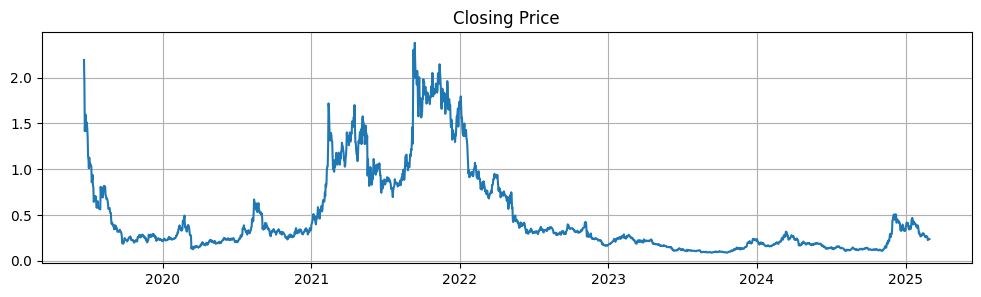

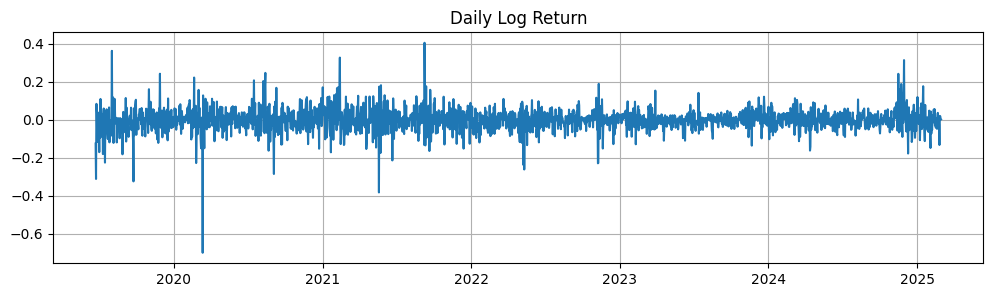

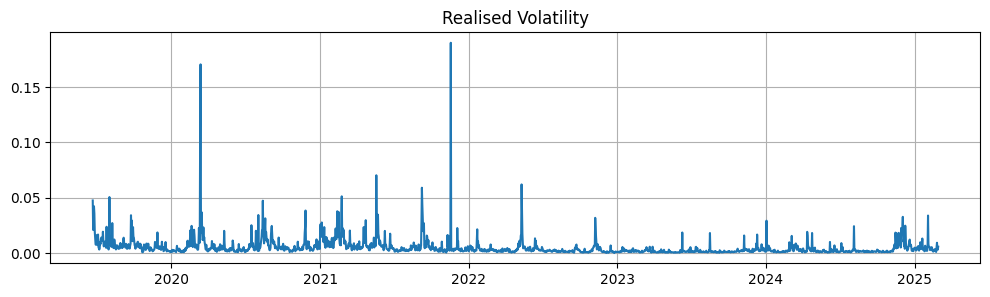

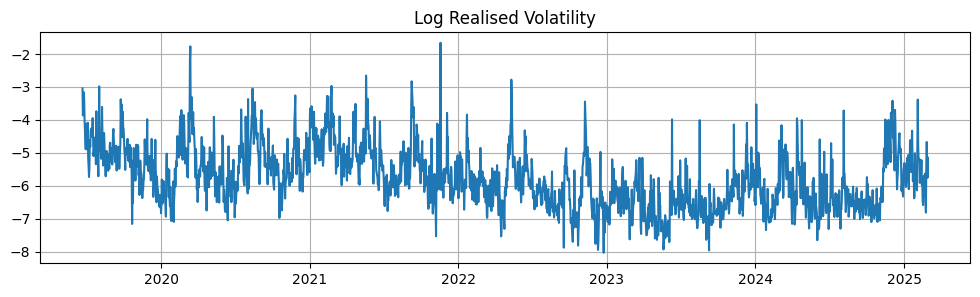

In [ ]:
gen_plot(df_daily['close'], "Closing Price")
gen_plot(df_daily['return'], "Daily Log Return")
gen_plot(df_daily['RV'], "Realised Volatility")
gen_plot(df_daily['lnRV'], "Log Realised Volatility")

### Summary Statistics

In [31]:
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample.

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. The test statistic is always nonnegative. If it is far from zero, it signals the data do not have a normal distribution.

In [40]:
summary_table = pd.DataFrame(index=['mean', 'median', 'std', 'min', 'max', 'skewness', 'kurtosis', 
                                    'ADF', 'ADF p-value', 'JB statistic', 'JB p-value'])

for c in df_daily.columns[3:7]:
    summary_table[c] = [df_daily[c].mean(), df_daily[c].median(), df_daily[c].std(),
                        df_daily[c].min(), df_daily[c].max(), df_daily[c].skew(),
                        df_daily[c].kurtosis(), adfuller(df_daily[c])[0], adfuller(df_daily[c])[1], 
                        stats.jarque_bera(df_daily[c]).statistic, stats.jarque_bera(df_daily[c]).pvalue]
print(summary_table.T)

            mean    median       std       min       max   skewness  \
close   0.468555  0.275400  0.460216  0.088700  2.379300   1.792433   
return -0.000478  0.001583  0.060005 -0.700566  0.405569  -0.697365   
RV      0.004918  0.002803  0.008421  0.000325  0.190018  11.349948   
lnRV   -5.802314 -5.877037  0.906478 -8.030840 -1.660635   0.531479   

          kurtosis        ADF   ADF p-value  JB statistic    JB p-value  
close     2.371221  -1.565520  5.008868e-01  1.548996e+03  0.000000e+00  
return   13.187538 -14.719603  2.765195e-27  1.471478e+04  0.000000e+00  
RV      205.601117 -10.302860  3.336939e-18  3.581719e+06  0.000000e+00  
lnRV      0.308010  -4.569715  1.468305e-04  1.026985e+02  5.003764e-23  


### Histogram and QQ-plot of daily log return series

In [45]:
import statsmodels.api as sm

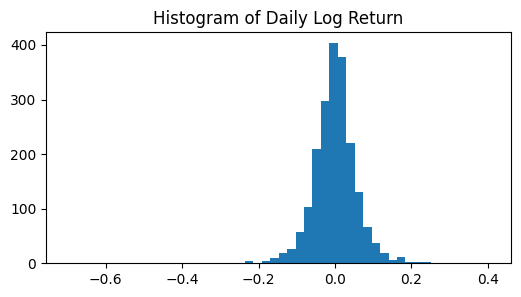

In [44]:
plt.figure(figsize=(6, 3))
plt.hist(df_daily['return'], bins=50)
plt.title('Histogram of Daily Log Return')
plt.show()

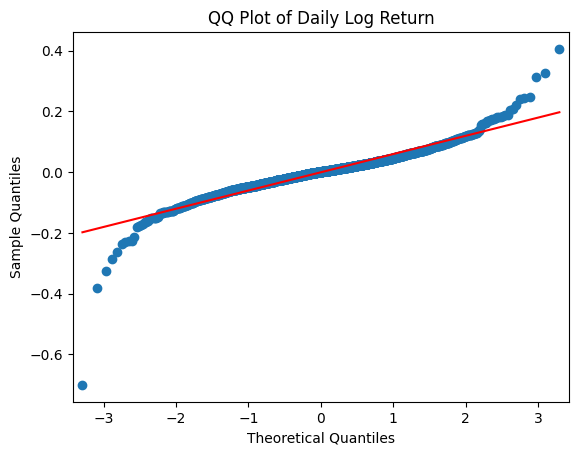

In [51]:
sm.qqplot(df_daily['return'], line ='s')
plt.title('QQ Plot of Daily Log Return')
plt.show()

### Histogram and QQ-plot of daily RV

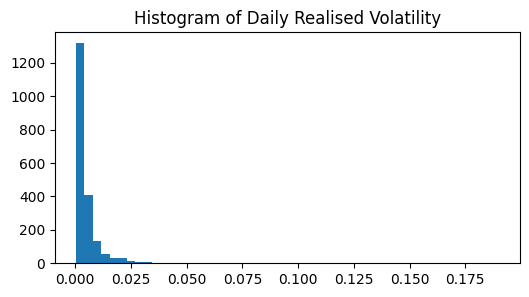

In [52]:
plt.figure(figsize=(6, 3))
plt.hist(df_daily['RV'], bins=50)
plt.title('Histogram of Daily Realised Volatility')
plt.show()

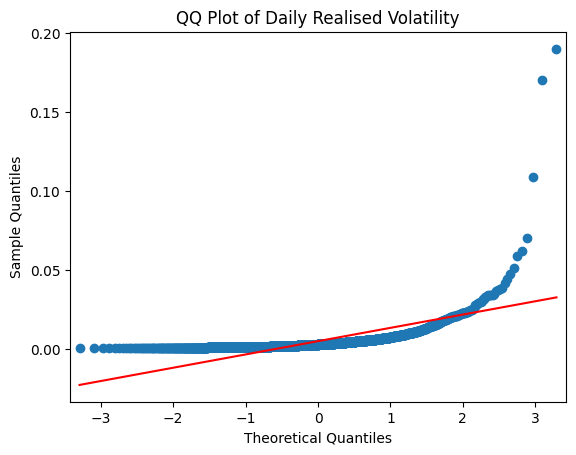

In [53]:
sm.qqplot(df_daily['RV'], line ='s')
plt.title('QQ Plot of Daily Realised Volatility')
plt.show()

### Save pre-processed data

In [19]:
df_daily.to_csv('..\data\ALGO_daily.csv')